In [38]:
import pandas as pd
import numpy as np
from collections import Counter
import math

### 0- Chargement du dataset

In [39]:
# def charger_dataset(file_name):
#     """Charge un fichier CSV et retourne le df."""
#     df = pd.read_csv('Dataset-Exos.txt', delimiter=',', header=None, names=['sepal_length','sepal_width','petal_length', 'petal_width', 'classe'])
#     #turn the 4 first columns into float
#     df[['sepal_length','sepal_width','petal_length', 'petal_width']] = df[['sepal_length','sepal_width','petal_length', 'petal_width']].astype(float)
#     df = df.dropna( )

#     return df

# df = charger_dataset('Dataset-Exos.txt')
def load(path):
 data = pd.read_csv(path, delimiter=',')
 
 return data
data=load("DatasetExos.csv")

In [40]:
# data['ep (ms)'] = pd.to_datetime(data['ep (ms)'])
data['ep (ms)'] =  data['ep (ms)'] .astype('category')  

data['Acc_x'] = pd.to_numeric(data['Acc_x'], errors='coerce') 
data['Acc_y'] = pd.to_numeric(data['Acc_y'], errors='coerce')  
data['Acc_z'] = pd.to_numeric(data['Acc_z'], errors='coerce')  
data['Gyro_x'] = pd.to_numeric(data['Gyro_x'], errors='coerce')  
data['Gyro_y'] = pd.to_numeric(data['Gyro_y'], errors='coerce')  
data['Gyro_z'] = pd.to_numeric(data['Gyro_z'], errors='coerce')  
data['ID'] = data['ID'].astype('category')  
data['Exercise'] = data['Exercise'].astype('category')  
data['Category'] = data['Category'].astype('category')  
data['Set'] = data['Set'].where(data['Set'] >= 0,0) 
data['Set'] = data['Set'].fillna(0)  
data['Set']= pd.to_numeric(data['Set'], errors='coerce') 

print(data.dtypes)
data = data.apply(
    lambda x: x.fillna(x.mode()[0]) if x.dtype == 'category' and x.mode().size > 0 else x.fillna(x.mean()) if x.dtype != 'category' else x,
    axis=0
)

ep (ms)     category
Acc_x        float64
Acc_y        float64
Acc_z        float64
Gyro_x       float64
Gyro_y       float64
Gyro_z       float64
ID          category
Exercise    category
Category    category
Set          float64
dtype: object


In [41]:
df = data.drop(columns=['Exercise','ID','ep (ms)','Category'])

In [42]:
# Q1 = df['sepal_width'].quantile(0.25)
# Q3 = df['sepal_width'].quantile(0.75)

# IQR = Q3 - Q1 

# outliers_threshold = 1.5 * IQR 
# max_outliers = Q3 + outliers_threshold
# min_outliers = Q1 - outliers_threshold

In [43]:
# column2 = df['sepal_width'][(df['sepal_width']< max_outliers) & (df['sepal_width'] > min_outliers)]
# df['sepal_width'] = column2
# df

In [44]:
# classes = df['classe']
# # remove column class
# df_copy = df.drop(columns=['classe'])
# df_copy = df_copy.apply(pd.to_numeric, errors='coerce')

# df_copy

#### Supression des valeurs null de notre dataset

In [45]:
# print(df_copy.isnull().sum())

In [46]:
df_copy = df

# print(df_copy.isnull().sum())

### 1- les fonctions permettant de calculer le distance entre deux instances du dataset.

In [47]:
def manhattan_distance(instance_a, instance_b):
        return sum(abs(a - b) for a, b in zip(instance_a, instance_b))

def euclidean_distance(instance_a, instance_b):
        return np.sqrt(sum((a - b)**2 for a, b in zip(instance_a, instance_b)))

def minkowski_distance(instance_a, instance_b, p):
        return sum(abs(a - b)**p for a, b in zip(instance_a, instance_b))**(1/p)

def cosine_distance(instance_a, instance_b):
        return 1 - (sum(a * b for a, b in zip(instance_a, instance_b)) / (np.sqrt(sum(a**2 for a in instance_a)) * np.sqrt(sum(b**2 for b in instance_b))))

def hamming_distance(instance_a, instance_b):
        return sum(a != b for a, b in zip(instance_a, instance_b))

### 2- fonction permettant de calculer le centroïde d’un ensemble d’instances.

In [48]:
def get_centroid(dataset, k):
    centroids = []  # List to store the centroids
    for _ in range(k):  # Loop k times to select k centroids
        centroids.append(dataset.sample(replace=False).iloc[0])  # Randomly select a single instance and add it to centroids
    return pd.DataFrame(centroids).reset_index(drop=True)  # Convert centroids to a DataFrame and reset index

# Get 3 centroids from the 'df_copy' dataset
get_centroid(df_copy, 3)

,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Set
0,0.581500,0.6880,-0.045,-15.9876,-49.4388,14.4512,23.0
1,0.010500,-1.5455,-0.040,45.8416,-16.6952,-28.5364,36.0
2,0.773667,-1.0720,0.310,-8.6950,-61.7318,-162.9390,23.0


### 3- fonction permettant de trouver le cluster dont une instance donnée est la plus proche.

In [49]:
def find_closest_cluster(instance, centroids, distance_function):

    centroids_df = pd.DataFrame(centroids)  # Convert centroids list to a DataFrame
    # Calculate distances between the instance and each centroid using the provided distance function
    distances = centroids_df.apply(lambda row: distance_function(row, instance), axis=1)
    return distances.idxmin()  # Return the index of the centroid with the minimum distance

# Find the closest cluster
centroids = get_centroid(df_copy, 3)  # Get 3 centroids
find_closest_cluster(df_copy.iloc[0], centroids, cosine_distance)  # Find the closest cluster for the first instance in 'df_copy'


2

### 5- Implémentation de l’algorithme k-means et déduction des clusters formés.

In [54]:
# Désactiver les messages d'avertissement pour les affectations en chaîne
pd.options.mode.chained_assignment = None  # par défaut='warn'

def kmeans(dataset, k, distance_function, max_iterations=100):
    # Choisir k instances aléatoirement comme centroïdes
    centroids = get_centroid(dataset, k)

    # Initialiser la colonne 'cluster' avec des valeurs aléatoires
    dataset['cluster'] = np.random.randint(0, k+5, size=len(dataset))

    for iteration in range(max_iterations):
        # Affecter chaque instance au groupe le plus proche de son centroïde
        clusters = dataset.apply(lambda row: find_closest_cluster(row[:-1], centroids, distance_function), axis=1)
        dataset['cluster'] = clusters

        # Mettre à jour les centroïdes
        # calculant la moyenne de chaque columns qui a le meme cluster 
        # new centroide position == (donc la moyenne des postions des clusters proche a le centroides "i")
        new_centroids = dataset.groupby('cluster').mean().reset_index(drop=True)
        # print(new_centroids)
        # Vérifier la convergence
        if centroids.equals(new_centroids):
            print('Après {} itérations, la convergence atteinte .'.format(iteration))
            break
        centroids = new_centroids

    return dataset,centroids 

# Exemple d'utilisation
k = 3
# result_dataset = kmeans(df_copy,k , cosine_distance)
#print(result_dataset)

In [ ]:
result_dataset

,Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,Set,cluster
0,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,30.0,1
1,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,30.0,1
2,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,30.0,1
3,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,30.0,1
4,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,30.0,1
...,...,...,...,...,...,...,...,...
9004,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,40.0,1
9005,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,40.0,1
9006,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,40.0,1
9007,-0.038667,-1.025667,-0.044667,-0.2318,0.2562,1.1220,40.0,1


# Evaluation des résultats en utilisant le coefficient de silhouette. 

Après 10 itérations, la convergence atteinte .
Results for k=2:
- Intra-cluster inertia (WCSS): 10492833991.19
- Silhouette score: 0.90

Après 30 itérations, la convergence atteinte .
Results for k=5:
- Intra-cluster inertia (WCSS): 551396218.83
- Silhouette score: 0.15

Après 15 itérations, la convergence atteinte .
Results for k=6:
- Intra-cluster inertia (WCSS): 547074471.75
- Silhouette score: 0.17



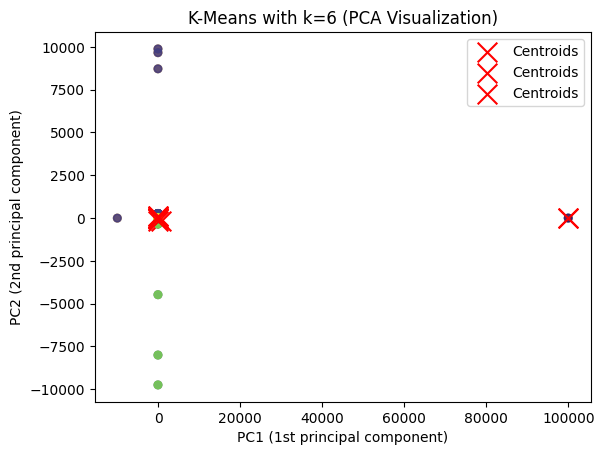

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
def evaluate_clusters(data, cluster_assignments):
    wcss = np.sum([np.linalg.norm(data[cluster_assignments == c] - np.mean(data[cluster_assignments == c], axis=0))**2
                   for c in np.unique(cluster_assignments)])
    silhouette_avg = silhouette_score(data, cluster_assignments)
    return wcss, silhouette_avg

# Visualize clusters with PCA
# def visualize_with_pca(data, cluster_assignments, centroids, title):
#     # Reduce data to 2D using PCA
#     pca = PCA(n_components=2)
#     data_2d = pca.fit_transform(data)
#     centroids_2d = pca.transform(centroids)

#     # Visualize clusters
#     plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis', s=30, alpha=0.6)
#     plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color='red', marker='x', s=200, label='Centroids')
#     plt.title(title)
#     plt.xlabel('PC1 (1st principal component)')
#     plt.ylabel('PC2 (2nd principal component)')
#     plt.legend()
for k in [2, 5, 6]:
    data, centroids = kmeans(df_copy,k , cosine_distance)
    wcss, silhouette_avg = evaluate_clusters(data, data['cluster'])
    
    # Visualize with PCA
    # visualize_with_pca(data.iloc[:, :-1], data['cluster'], centroids, f"K-Means with k={k} (PCA Visualization)")
    
    # Print evaluation results
    print(f"Results for k={k}:")
    print(f"- Intra-cluster inertia (WCSS): {wcss:.2f}")
    print(f"- Silhouette score: {silhouette_avg:.2f}")
    print()